# Refining Raw Audio

In this tutorial, you will learn how to apply `VocalForge.audio` pipelines on audio files.

Each pipeline will (or at least attempt to) remove poor/inappropiate audio from each file in order to better prime it for dataset creation, or whatever other purpose you have in mind. These can be done in different order, or some not at all. It's up to you!

The models generally consist of a neural network designed to identify a specific piece of audio, then mark timestamps for its removal. Let's go over the ones currently supported in order to better illistrates VocalForge's usefulness:

- `Voice Detection` will remove segments of audio in which no human sounds are found. Say there is a long segment of city noise, or a musical intro to a podcast, all of this is removed. This is helpful not only in that it removes any of that non human audio, but it also reduces the time in which the subsequent audio takes to process.

- `Overlap` covers speech that has two or more people talking at the same time. Not only does it forceably remove egotistical people from trying to take over a conversation, but it *also* removes poor audio from podcasts or other casual conversational settings.

- `Isolate` one of the less straightforward pipelines, it goes through and seperates each speaker in each audio file. From there, you as a user can specify a specific speaker you want to target and it will find that same user across each audio file, even in different recording enviroments, such as a recording studio and a park. 

- `Export` is really just to put everything in a nice little bow. Given a directory, it will format on sample rate, as well as optionally normalize and noise reduce the audio. 

More pipelines are coming soon™

NOTE: It is highly reccomended to run this on a conda enviroment if running locally by running the command
`conda create -n VocalForge python=3.8 pytorch=1.11.0 torchvision=0.12.0 torchaudio=0.11.0 cudatoolkit=11.3.1 -c pytorch`

### Getting Started

First, let's get to creating our work directory and installing `VocalForge`

In [1]:
import os
root_path = os.getcwd()
print(root_path)
!mkdir os.path.join(root_path, 'work')
!mkdir os.path.join(root_path, 'work/audio')
work_path = os.path.join(root_path, 'work/audio')

/home/rio/Desktop/VocalForgeDev/VocalForge
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `mkdir os.path.join(root_path, 'work')'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `mkdir os.path.join(root_path, 'work/audio')'


In [ ]:
#this might take a while
!pip install VocalForge['audio']

In [3]:
from VocalForge.audio.audio_utils import create_core_folders
create_core_folders(['RawAudio', 'Samples', 'VD', 'Overlap', 'Verification', 'Isolated', 'Exported', 'Noise_Removed', 'Normalized'], workdir=os.path.join(root_path, 'work/audio'))

/home/rio/anaconda3/envs/VocalForge/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Alright cool, thats all taken care of. Now for the sake of our demo, we will download a YouTube Playlist of Joe Biden, however you could link your own playlist or simply drop your own local wav files into the `RawAudio` folder.

In [ ]:
from VocalForge.audio.audio_utils import download_videos

download_videos(url='https://www.youtube.com/playlist?list=PLAVNH_8nglubKvZ8bdiEjf9IKKB73SvIy', out_dir=os.path.join(work_path, 'RawAudio'))

For actual production, we would want to process all the audio we can get our grubby hands on. But for the purposes of our demo, we will be trimming each audio down to 5 minutes using the `create_samples` method  

In [5]:
from VocalForge.audio.audio_utils import create_samples

create_samples(
    length=300,
    input_dir=os.path.join(work_path, 'RawAudio'),
    output_dir=os.path.join(work_path, 'Samples'),
)

### Voice Activity

Initialize the class and set the paths of what the input files are, and where to output the filtered files are.

In [ ]:
from VocalForge.audio import VoiceDetection
VD = VoiceDetection(
    input_dir=os.path.join(work_path, 'Samples'),
    output_dir=os.path.join(work_path, 'VD'),
)

VD.run()

Alright! Lets check out the timeline of an audio file to see what parts got deleted.

In [ ]:
VD.Timelines[3]

In [ ]:
#show audio file ipython
from IPython.display import Audio
Audio(os.path.join(work_path, 'Samples', 'DATA3.wav'))

Let's say that the audio highlighted in red has too many short breaks which cause to abrupt cuts in the audio. we can change around some model parameters to change this. by modifying the `min_duration_off` and `min_duration_on` values

In [4]:

HYPER_PARAMETERS = {
  # onset/offset activation thresholds
  "onset": 0.2, "offset": 0.6,
  # remove speech regions shorter than that many seconds.
  "min_duration_on": 1.0,
  # fill non-speech regions shorter than that many seconds.
  "min_duration_off": 1.0
}

The default values are normally:

`Onset: 0.5`
`Offset: 0.5`
`min_duration_on: 0.0`
`min_duration_off: 0.0`

One can change any of these values to make the values a little more or less liberal in what is speech and what's not (see what I did there?). This can also be used for overlapping speech, however this feature does not exist for isolating voices.

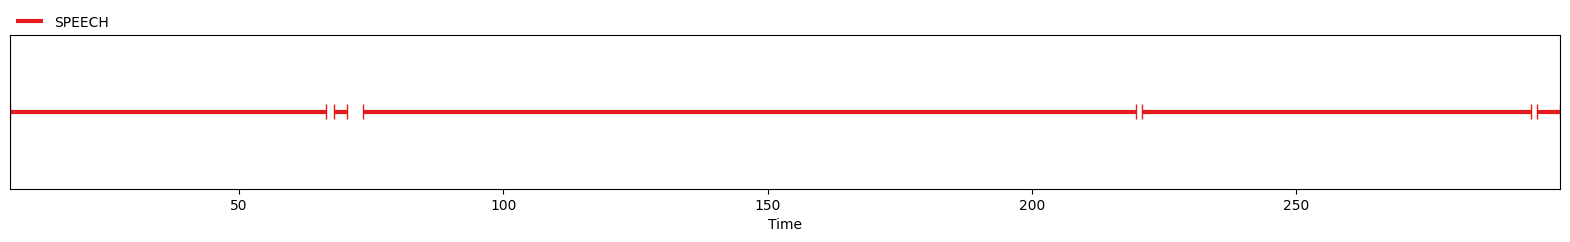

In [5]:
VD.Hparams = HYPER_PARAMETERS
tuned = VD.analyze_file(os.path.join(work_path, 'Samples', 'DATA3.wav'))
tuned

If you wanna go *really* in depth, you could go through each file and change the parameters to get everything as close to perfect as possible. You can then overwrite the default values by doing

In [6]:
VD.update_timeline(tuned, 3)

Now we have a nicely tuned While this file is nicely edited and doesnt include many periods of non speech, some files may be significantly slimmed down.

We can also take a peak into other metrics, which could be used for post processing or fancy dancy post processing you want down the line that I haven't included:

In [7]:
from VocalForge.audio.audio_utils import calculate_duration, find_duration_diff, find_original_duration
print(f"total speech duration: {round(calculate_duration(VD.Timestamps[3]), 2)} seconds")
for timestamps in VD.Timestamps[3]:
    print(f"start: {round(timestamps[0], 2)}, end: {round(timestamps[1], 2)}")
print(f"time cut: {round(find_duration_diff(new_timestamps=VD.Timestamps[3], original_duration=find_original_duration(VD.Input_Files[3])), 2)} seconds")

total speech duration: 286.35 seconds
start: 6.56, end: 66.43
start: 68.03, end: 70.36
start: 73.35, end: 219.64
start: 220.89, end: 294.43
start: 295.62, end: 299.94
time cut: 13.65 seconds


### Implementing The Other Classes

This section will be signiciantly more brief as the process is very similar to the above class, however there are a few things to point out.

In [ ]:
# Overlap Detection
from VocalForge.audio import Overlap

OverlapDetection = Overlap(
    input_dir=os.path.join(work_path, 'VD'),
    output_dir=os.path.join(work_path, 'Overlap')
)
OverlapDetection.run()
print(f"Time remaining: {round(find_duration_diff(new_timestamps=OverlapDetection.Timestamps[3], original_duration=find_original_duration(OverlapDetection.Input_Files[3])), 2)} seconds")

To seperate speakers and isolate a specific person is a two step process, but in one class for the sake of simplicity. If you only plan to seperate speakers and not to isolate a specific voice, then just don't declare the variables related to the isolating processes.

What the is happening here is that the isolating NN iterates through all the files in the `input_dir`, and saves each voice as a seperate wav file in `verification_dir` with the original audio file being now a folder. This can be taken further by isolating a specific voice from the dataset. First, it prompts the user to specify a path to a wav file containing the voice of the speaker. This can be either done through an input() prompt, or specified in the class through the `speaker_id` variable. If you have already calculate the voice data on your own, you can input the info under `speaker_fingerprint`.

After that is done and over with, it will iterate through each speaker and compare the speech similaries. The `verification_threshold` is the score it must reach in order to be considered the same person and can be modified as need be. Say that all the speakers in a file does not match the voice enough to reach verification_threshold, the process will repeat by negating 0.05 to verification_threshold until it reaches the `lowest_threshold`, or finds a match. You can disable this feature by simply setting the lowest threshold to the same value as verification_threshold.

In [2]:
from VocalForge.audio.isolate import Isolate

IsolateVoices = Isolate(
    input_dir=os.path.join(work_path, 'VD'),
    verification_dir=os.path.join(work_path, 'Verification'), #this is where the seperated voices will be saved
    export_dir=os.path.join(work_path, 'Isolated'), #this is where the targeted voice will be saved
    verification_threshold=0.9, #this is the threshold for two voices to be considered a match (0.00-1.00)
    lowest_threshold=0.5, #this is the lowest threshold for a voice to be considered a match if *no* matches are found in the entire file (0.00-1.00)
    speaker_id=None,
    speaker_fingerprint=None,
)

/home/rio/anaconda3/envs/VocalForge/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#seperate speakers
IsolateVoices.run_separate_speakers()

In [5]:
#input path to target speaker or specify file through IsolateVoices.Speaker_Id = 'path/to/file'
IsolateVoices.run_verification()

Now to export. This is how we can define the final output of the wav files. 

By declaring a directory to `noise_removed_dir` will apply deepfilternet2 to each audio file to reduce noise. I find that this specific NN works best compared to solutions like the Adobe Podcast Audio Upscaler for tasks like TTS training or some other application that requires natural audio processing.

`normalization_dir`, if declared, will export a copy of the exported audio with normalized audio.

In [8]:
from VocalForge.audio import ExportAudio
Exported = ExportAudio(
    input_dir=os.path.join(work_path, 'Isolated'),
    export_dir=os.path.join(work_path, 'Exported'),
    noise_removed_dir=os.path.join(work_path, 'Noise_Removed'),
    normalization_dir=os.path.join(work_path, 'Normalized'),
    sample_rate=22050,
)

In [9]:
Exported.run()

Removing Noise...
2023-06-03 22:26:50 | INFO     | DF | Loading model settings of DeepFilterNet2
2023-06-03 22:26:50 | INFO     | DF | Using DeepFilterNet2 model at /home/rio/.cache/DeepFilterNet/DeepFilterNet2
2023-06-03 22:26:51 | INFO     | DF | Initializing model `deepfilternet2`
2023-06-03 22:26:51 | INFO     | DF | Found checkpoint /home/rio/.cache/DeepFilterNet/DeepFilterNet2/checkpoints/model_96.ckpt.best with epoch 96
2023-06-03 22:26:51 | INFO     | DF | Running on device cuda:0
2023-06-03 22:26:51 | INFO     | DF | Model loaded
Removing Noise from DATA0.wav...
Removing Noise from DATA1.wav...
Removing Noise from DATA3.wav...
Removing Noise from DATA4.wav...
Removing Noise from DATA5.wav...
Normalizing Audio...


And you're done! Well, sort of. While this process does a pretty good job, to get the best results you will want to check the results manually. As I add more filters, this process will hopefully increase in resolution to reduce the time needed to review the output. But for now, stay vigilent.

Next, we will be going over how to format this now refined audio into a dataset ready and prepped for a NN. Stay tuned!